In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import timeseriesanalysis as tsa
!pip install bezier
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
import itertools
from scipy.special import comb
from scipy import signal

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.3 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
lang

In [ ]:
def arithmetic_mean(data, window_size):
    """
    Computes the arithmetic mean (simple moving average) over a sliding window.

    Parameters:
    data (numpy.ndarray): The input 1D array for which to compute the arithmetic mean.
    window_size (int): The size of the sliding window.

    Returns:
    numpy.ndarray: A 1D array of the arithmetic mean values, padded with zeros for alignment.
    """
    # Create a convolution kernel with equal weights
    kernel = np.ones(window_size) / window_size
    sma = np.convolve(data, kernel, mode='valid')

    # Prepend zeros to match the original data length
    mean = np.concatenate((np.zeros(len(data) - len(sma)), sma))

    return mean


In [ ]:
def generate_polynomial_kernel(coefficients, window_size):
    """
    Generates a filter kernel by evaluating a polynomial defined by the given coefficients.

    Parameters:
    coefficients (numpy.ndarray): A 1D array of polynomial coefficients, ordered from highest to lowest degree.
    window_size (int): The size of the window over which the polynomial is evaluated.  Must equal len(coefficients).

    Returns:
    numpy.ndarray: A 1D array representing the normalized filter kernel.
    """
    if len(coefficients) != window_size:
        raise ValueError("The number of coefficients must equal the window size.")

    x = np.linspace(0, 1, window_size)  # Scale the x-values for polynomial evaluation.
    kernel = np.polyval(coefficients[::-1], x) #Evaluate the polynomial.  Flip the coefficients because numpy expects it in reverse.
    kernel_sum = np.sum(kernel)

    if kernel_sum != 0:
        kernel = kernel / kernel_sum
    else:
        return np.zeros(window_size) # or handle it in the error

    return kernel

def lti_filter_via_convolution_precomputed(data, kernel):
    """
    Applies a linear time-invariant (LTI) filter to the input data using convolution,
    assuming the kernel has already been precomputed and normalized.

    Parameters:
    data (numpy.ndarray): The input 1D array to be filtered.
    kernel (numpy.ndarray): The precomputed and normalized filter kernel.

    Returns:
    numpy.ndarray: A 1D array of the filtered data, padded with zeros for alignment.
    """
    filtered_data = np.convolve(data, kernel, mode='valid')
    padding_size = len(data) - len(filtered_data)
    filtered_data_padded = np.concatenate((np.zeros(padding_size), filtered_data))

    return filtered_data_padded


# Example Usage: Efficient Iteration
if __name__ == '__main__':
    data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    window_size = 3
    coefficient_sets = [
        np.array([0.1, 0.2, 0.7]),  # linear
        np.array([0.25, 0.5, 0.25]), # linear
        np.array([-0.5, 1.0, -0.5]), # linear
        np.array([1, 0, 0]),       #Quadratic
        np.array([1, 1, 1])        #Quadratic
    ]

    # Precompute the kernels
    kernels = [generate_polynomial_kernel(coeffs, window_size) for coeffs in coefficient_sets]

    # Now, efficiently iterate and apply the filters
    for i, kernel in enumerate(kernels):
        filtered_data = lti_filter_via_convolution_precomputed(data, kernel)
        print(f"Filtered data for coefficient set {i+1}:", filtered_data)
        print(f"Kernel values for coefficient set {i+1}:", kernel)

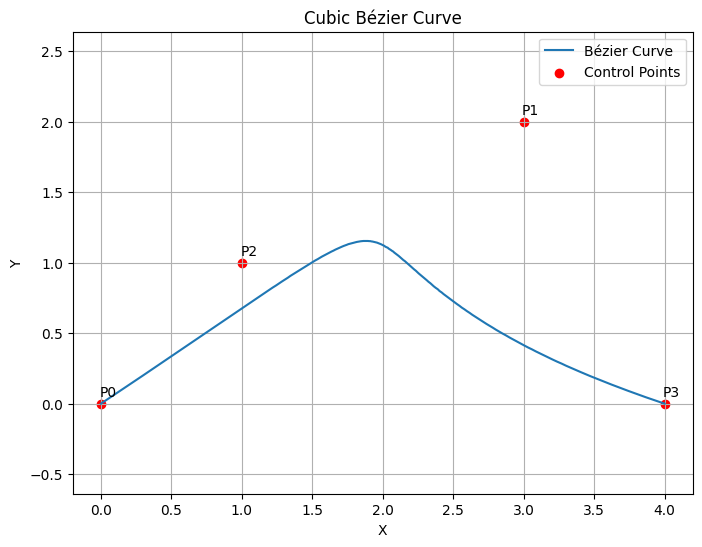

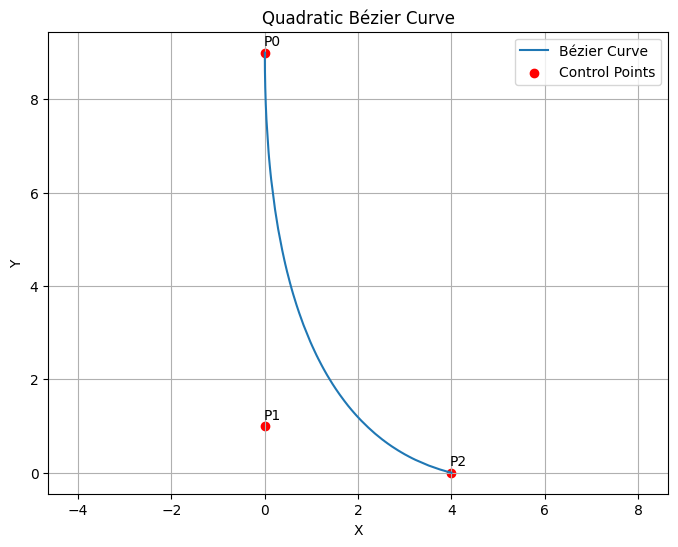

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def bezier_curve(control_points, num_points=100):
    """
    Generates a 2D Bézier curve.

    Args:
        control_points (list or numpy array): A list or NumPy array of (x, y)
            tuples or coordinates representing the control points of the Bézier curve.
            Must be a 2D array.  For a degree n curve, there should be n+1 points.

        num_points (int): The number of points to generate along the curve.
            Defaults to 100.

    Returns:
        numpy array: A NumPy array of shape (num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curve.
    """

    control_points = np.asarray(control_points)

    if control_points.ndim != 2 or control_points.shape[1] != 2:
        raise ValueError("Control points must be a 2D array of (x, y) coordinates.")

    n = control_points.shape[0] - 1  # Degree of the Bézier curve

    if n < 1:
        raise ValueError("At least two control points are required.")

    def bernstein_polynomial(i, n, t):
        """
        Calculates the i-th Bernstein basis polynomial of degree n at parameter t.
        """
        from scipy.special import comb #Combination function
        return comb(n, i) * t**i * (1 - t)**(n - i)

    points = np.zeros((num_points, 2), dtype=np.float16)

    for j in range(num_points):
        t = j / (num_points - 1)  # Parameter t ranges from 0 to 1

        for i in range(n + 1):
            bernstein = bernstein_polynomial(i, n, t)
            points[j, :] += bernstein * control_points[i, :]

    return points


if __name__ == '__main__':
    # Example Usage

    # Cubic Bézier Curve
    control_points = [
        (0, 0),
        (3, 2),
        (1, 1),
        (4, 0)
    ]

    curve_points = bezier_curve(control_points, num_points=200)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points[:, 0], curve_points[:, 1], label='Bézier Curve')
    plt.scatter([p[0] for p in control_points], [p[1] for p in control_points],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Cubic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

    #Quadratic bezier curve

    control_points_quadratic = [
        (0, 9),
        (0, 1),
        (4, 0)
    ]

    curve_points_quadratic = bezier_curve(control_points_quadratic, num_points=1000)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points_quadratic[:, 0], curve_points_quadratic[:, 1], label='Bézier Curve')
    plt.scatter([p[0] for p in control_points_quadratic], [p[1] for p in control_points_quadratic],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points_quadratic):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Quadratic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

In [5]:
curve_points_quadratic[:, 1].dtype

dtype('float16')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bezier_curve(control_points, num_points=100):
    """
    Generates a 2D Bézier curve.
    """
    control_points = np.asarray(control_points)
    n = control_points.shape[0] - 1

    def bernstein_polynomial(i, n, t):
        from scipy.special import comb
        return comb(n, i) * t**i * (1 - t)**(n - i)

    points = np.zeros((num_points, 2), dtype=np.float16)

    for j in range(num_points):
        t = j / (num_points - 1)
        for i in range(n + 1):
            bernstein = bernstein_polynomial(i, n, t)
            points[j, :] += bernstein * control_points[i, :]

    return points


# Quadratic Control Points
quadratic_control_points = [(0, 0), (1, 1), (2, 0)]
quadratic_curve = bezier_curve(quadratic_control_points)

# Cubic Control Points (Using Quadratic Points + Same Start Point for Last Point)
cubic_control_points = [(0, 0), (1, 1), (2, 0), (0, 0)]
cubic_curve = bezier_curve(cubic_control_points)


# Plotting
plt.figure(figsize=(8, 6))
plt.plot(quadratic_curve[:, 0], quadratic_curve[:, 1], label='Quadratic Bézier')
plt.plot(cubic_curve[:, 0], cubic_curve[:, 1], label='Cubic Bézier (Same Points)')
plt.scatter([p[0] for p in quadratic_control_points], [p[1] for p in quadratic_control_points],
            color='red', marker='o', label='Control Points')

plt.title('Quadratic vs. Cubic Bézier Curves')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

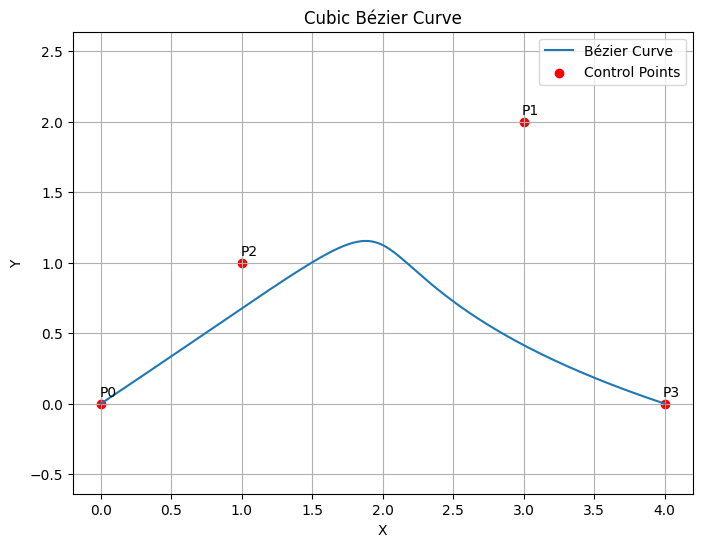

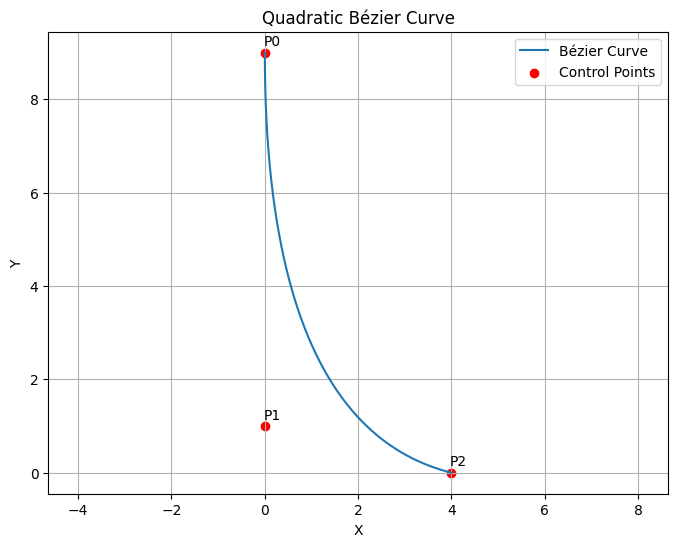

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def bezier_curve_fast(control_points, num_points=100):
    """
    Generates a 2D Bézier curve, optimized for speed using NumPy.

    Args:
        control_points (numpy array): A NumPy array of shape (n+1, 2)
            representing the control points of the Bézier curve.
        num_points (int): The number of points to generate along the curve.

    Returns:
        numpy array: A NumPy array of shape (num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curve.
    """

    control_points = np.asarray(control_points)
    n = control_points.shape[0] - 1

    # Precompute Bernstein basis polynomials for all t values
    t = np.linspace(0, 1, num_points)[:, None]  # Create a column vector of t values

    #Precompute the binomial coefficients, use this to further vectorize the binomial polynomial function
    binomial_coefficients = np.array([comb(n, i) for i in range(n + 1)])

    # Vectorized calculation of Bernstein polynomials, for the best speed
    bernstein_polynomials = binomial_coefficients * (t ** np.arange(n + 1).reshape(1, -1)) * ((1 - t) ** np.arange(n, -1, -1).reshape(1, -1))

    # Calculate curve points using vectorized operations
    points = np.dot(bernstein_polynomials, control_points)

    return points


if __name__ == '__main__':
    # Example Usage

    # Cubic Bézier Curve
    control_points = np.array([  # Use NumPy array directly
        [0, 0],
        [3, 2],
        [1, 1],
        [4, 0]
    ])

    curve_points = bezier_curve_fast(control_points, num_points=200)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points[:, 0], curve_points[:, 1], label='Bézier Curve')
    plt.scatter(control_points[:, 0], control_points[:, 1],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Cubic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

    #Quadratic bezier curve

    control_points_quadratic = np.array([
        [0, 9],
        [0, 1],
        [4, 0]
    ])

    curve_points_quadratic = bezier_curve_fast(control_points_quadratic, num_points=1000)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points_quadratic[:, 0], curve_points_quadratic[:, 1], label='Bézier Curve')
    plt.scatter(control_points_quadratic[:, 0], control_points_quadratic[:, 1],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points_quadratic):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Quadratic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def bezier_curve_fast(control_points, num_points=100):
    """
    Generates a 2D Bézier curve, optimized for speed using NumPy,
    and scales the curve so that its points sum to 1.

    Args:
        control_points (numpy array): A NumPy array of shape (n+1, 2)
            representing the control points of the Bézier curve.
        num_points (int): The number of points to generate along the curve.

    Returns:
        numpy array: A NumPy array of shape (num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curve, scaled to sum to 1.
    """

    control_points = np.asarray(control_points)
    n = control_points.shape[0] - 1

    # Precompute Bernstein basis polynomials for all t values
    t = np.linspace(0, 1, num_points)[:, None]  # Create a column vector of t values

    #Precompute the binomial coefficients, use this to further vectorize the binomial polynomial function
    binomial_coefficients = np.array([comb(n, i) for i in range(n + 1)])

    # Vectorized calculation of Bernstein polynomials, for the best speed
    bernstein_polynomials = binomial_coefficients * (t ** np.arange(n + 1).reshape(1, -1)) * ((1 - t) ** np.arange(n, -1, -1).reshape(1, -1))

    # Calculate curve points using vectorized operations
    points = np.dot(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = np.sum(points)
    if curve_sum != 0:  # Avoid division by zero
        points = points / curve_sum

    return points


if __name__ == '__main__':
    # Example Usage

    # Cubic Bézier Curve
    control_points = np.array([  # Use NumPy array directly
        [0, 0],
        [3, 2],
        [1, 1],
        [4, 0]
    ])

    curve_points = bezier_curve_fast(control_points, num_points=200)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points[:, 0], curve_points[:, 1], label='Bézier Curve')
    plt.scatter(control_points[:, 0], control_points[:, 0],
                color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Cubic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

    #Quadratic bezier curve

    control_points_quadratic = np.array([
        [0, 9],
        [0, 1],
        [4, 0]
    ])

    curve_points_quadratic = bezier_curve_fast(control_points_quadratic, num_points=10)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(curve_points_quadratic[:, 0], curve_points_quadratic[:, 1], label='Bézier Curve')
    #plt.scatter(control_points_quadratic[:, 0], control_points_quadratic[:, 1],
               # color='red', marker='o', label='Control Points')

    # Add labels to control points
    for i, point in enumerate(control_points_quadratic):
        plt.annotate(f'P{i}', point, textcoords="offset points", xytext=(5,5), ha='center')

    plt.title('Quadratic Bézier Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure x and y axes have the same scale
    plt.show()

In [3]:
def bezier_curve_fast(control_points, num_points=100):
    """
    Generates a 2D Bézier curve, optimized for speed using NumPy,
    and scales the curve so that its points sum to 1.

    Args:
        control_points (numpy array): A NumPy array of shape (n+1, 2)
            representing the control points of the Bézier curve.
        num_points (int): The number of points to generate along the curve.

    Returns:
        numpy array: A NumPy array of shape (num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curve, scaled to sum to 1.
    """

    control_points = np.asarray(control_points)
    n = control_points.shape[0] - 1

    # Precompute Bernstein basis polynomials for all t values
    t = np.linspace(0, 1, num_points)[:, None]  # Create a column vector of t values

    #Precompute the binomial coefficients, use this to further vectorize the binomial polynomial function
    binomial_coefficients = np.array([comb(n, i) for i in range(n + 1)])

    # Vectorized calculation of Bernstein polynomials, for the best speed
    bernstein_polynomials = binomial_coefficients * (t ** np.arange(n + 1).reshape(1, -1)) * ((1 - t) ** np.arange(n, -1, -1).reshape(1, -1))

    # Calculate curve points using vectorized operations
    points = np.dot(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = np.sum(points)
    if curve_sum != 0:  # Avoid division by zero
        points = points / curve_sum

    return points.astype(np.float16)

def generate_coordinate_arrangements_lists():
    """
    Generates all possible coordinate arrangements for three points,
    where each coordinate pair is a list instead of a tuple.

    Point 1: x = 0, y = 0 to 10
    Point 2: x = 0 to 4, y = 0 to 10
    Point 3: x = 4, y = 0 to 10

    Returns:
        A list of lists, where each inner list represents an arrangement of the three points.
        Each inner list contains the [x, y] coordinates of each point:
        [[x1, y1], [x2, y2], [x3, y3]].
    """
    arrangements = []
    for y1 in range(0, 11):
        for x2 in range(0, 5):
            for y2 in range(0, 11):
                for y3 in range(0, 11):
                    # Create the arrangement list (instead of a tuple):
                    point1 = [0, y1]
                    point2 = [x2, y2]
                    point3 = [4, y3]
                    arrangements.append(np.array([point1, point2, point3]))  # Append a list of lists

    return arrangements

all_arrangements = generate_coordinate_arrangements_lists()
min_window_size = 10
max_window_size = 1000
window_size_step = 10
loop_points = range(min_window_size, max_window_size, window_size_step)
enum_loop_points = enumerate(loop_points)

kernel_functions = np.zeros((len(loop_points), len(all_arrangements)+1), dtype=object)

with tqdm(desc="Processing") as pbar:
    for window_index, window_size in enumerate(range(10, 1000, 10)):
        for arrangement_index, arrangement in enumerate(all_arrangements):
            kernel_functions[window_index, arrangement_index] = bezier_curve_fast(arrangement, num_points=window_size)[:, 1]
        pbar.update(1)  # Increment the progress bar by 1
        #pbar.set_postfix({"iteration": i + 1})  # Add custom information

Processing: 99it [01:50,  1.12s/it]


In [9]:
kernel_functions[1][60]

array([0.      , 0.0055  , 0.010704, 0.01561 , 0.02022 , 0.02454 ,
       0.02855 , 0.03226 , 0.03568 , 0.03882 , 0.04163 , 0.04416 ,
       0.0464  , 0.0483  , 0.04996 , 0.0513  , 0.05234 , 0.05307 ,
       0.05353 , 0.05368 ], dtype=float16)